# Import

In [1]:
%pip install tensorflow keras


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import keras_tuner as kt
from tensorflow.keras.models import load_model

In [5]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MaxAbsScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import hmmlearn.hmm
from hmmlearn.hmm import GaussianHMM
from sklearn_crfsuite import CRF
from sklearn.metrics import log_loss, hinge_loss, precision_score, recall_score, f1_score, roc_auc_score

In [7]:
## Options
pd.set_option("max_colwidth", None)

In [8]:
# Get the absolute path to the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(project_root)
print(project_root)

e:\2_LEARNING_BKU\2_File_2\K22_HK242\CO3117_Machine_Learning\Main


In [9]:
from src.features.build_features_utils import *  # Assuming build_features_utils is inside build_features.py
from src.models.models_utils import *  # Assuming utils.py exists inside src/models/

e:\anaconda3\envs\ml_env_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dict

In [10]:
# Dictionary for models
MODEL_DICT = {
    "decision_tree": DecisionTreeClassifier,
    "perceptron": Perceptron,
    "mlp": MLPClassifier,
    "bayesian": GaussianNB,
    "random_forest": RandomForestClassifier,
    "xgboost": xgb.XGBClassifier,
    "svm": SVC,
    "logistic_regression": LogisticRegression,
    "crf": lambda: CRF(
        algorithm="lbfgs",  # Default: lbfgs
        max_iterations=100,  # Limit iterations to prevent overfitting
        all_possible_transitions=True
    )
} 

# Dictionary for model parameters
MODEL_PARAMS = {
    # "decision_tree": {
    #     "criterion": ["gini", "entropy"],
    #     "max_depth": [10, 20],
    #     "min_samples_split": [2, 5],
    #     "min_samples_leaf": [1, 2],
    #     "max_features": ["sqrt", "log2"]
    # },
    
    "decision_tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, 40],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"]
    },
    
    # "perceptron": {
    #     "max_iter": [1000, 2000],
    #     "tol": [1e-3],
    #     "eta0": [0.001],
    #     "penalty": ["l2"],
    #     "alpha": [0.0001, 0.001]
    # },
    
    "perceptron": {
        "max_iter": [1000, 2000],
        "tol": [1e-3, 1e-4],
        "eta0": [0.001, 0.01, 0.1],
        "penalty": [None, "l2", "l1"],
        "alpha": [0.0001, 0.001, 0.01]
    },
    
    "mlp": {
        "hidden_layer_sizes": [(50,), (100,)],
        "activation": ["tanh", "logistic"],
        "solver": ["sgd"],
        "alpha": [0.0001, 0.001, 0.01],
        "batch_size": [32],
        "max_iter": [1000],
    },
    
    # "mlp": {
    #     "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100)],
    #     "activation": ["relu", "tanh", "logistic"],
    #     "solver": ["adam", "sgd"],
    #     "alpha": [0.0001, 0.001, 0.01],
    #     "batch_size": [32, 64, 128],
    #     "max_iter": [500, 1000],
    #     "learning_rate": ["constant", "invscaling", "adaptive"]
    # },
    
    "bayesian": {
        "priors": [None, [0.5, 0.5], [0.4, 0.6], [0.3, 0.7], [0.2, 0.8], [0.1, 0.9], [0.05, 0.95]],
        "var_smoothing": [1e-9, 1e-8, 1e-7]
    },
    
    "random_forest": {
        "n_estimators": [100, 200],
        "max_depth": [10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False]
    },
    
    # "random_forest": {
    #     "n_estimators": [50, 100, 200],
    #     "max_depth": [None, 10, 20, 30],
    #     "min_samples_split": [2, 5, 10],
    #     "min_samples_leaf": [1, 2, 4],
    #     "max_features": ["auto", "sqrt", "log2"],
    #     "bootstrap": [True, False]
    # },
    
    # "xgboost": {
    #     "n_estimators": [100],
    #     "learning_rate": [0.01, 0.1],
    #     "max_depth": [6, 10]
    # },
    
    # "xgboost": {
    #     "n_estimators": [100, 200, 300],
    #     "learning_rate": [0.01, 0.1, 0.2],
    #     "max_depth": [3, 6, 10],
    #     "subsample": [0.8, 1.0],
    #     "colsample_bytree": [0.8, 1.0],
    #     "gamma": [0, 0.1, 0.2]
    # },
    
    "svm": {
        "kernel": ["linear"],
        "C": [0.001, 0.01, 0.1, 1],
        "gamma": [0.1, 0.01, "scale", "auto"]
    },
    
    # "svm": {
    #     "kernel": ["linear", "rbf", "poly"],
    #     "C": [0.1, 1, 10, 100],
    #     "gamma": [0.1, 0.01, "scale", "auto"],
    #     "degree": [2, 3, 4]
    # },
    
    # "logistic_regression": {
    #     "penalty": ["l2"],
    #     "C": [0.1, 1.0],
    #     "max_iter": [1000, 2000]
    # },
    
    "logistic_regression": {
        "penalty": ["l1", "l2", "elasticnet", None],
        "C": [0.1, 1.0, 10.0],
        "max_iter": [1000, 2000]
    },
    
    
    # "hmm": {
    #     "n_components": [2],  # Keep it small
    #     "covariance_type": ["diag"],  # Simpler covariance type
    #     "n_iter": [500],  # Reduce iterations
    #     "init_params": ["stmc"],  # Initialize start probabilities, transition matrix, and means/covariance
    #     "params": ["stmc"]
    # },
    
    # "hmm": {
    #     "n_components": [2, 3, 4],
    #     "covariance_type": ["diag", "full", "tied"],
    #     "n_iter": [100, 200],
    #     "init_params": ["c", "s", "cs"],
    #     "params": ["c", "t", "ct"]
    # },
    
    # "crf": {
    #     "c1": [0.1, 0.01],  # L1 Regularization
    #     "c2": [0.1, 0.01],  # L2 Regularization
    #     "max_iterations": [50, 100]  # Limit iterations
    # }
}

# Dictionary for dimensionality reduction methods
DIMENSIONALITY_REDUCTION_DICT = {
    "pca": PCA,
    "lda": LDA,
}

# Load dataset

In [11]:
# Load dataset
dataset_path = os.path.join(project_root, "data", "final", "final_clean_no_neutral_no_duplicates.csv")
df = pd.read_csv(dataset_path)


In [12]:
df.head()

,target,text,text_clean,text_length,text_clean_length
0,0.0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww thats a bummer you shoulda got david carr of third day to do it d,19,16
1,0.0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cant update his facebook by texting it and might cry a a result school today also blah,21,21
2,0.0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,i dived many time for the ball managed to save the rest go out of bound,18,16
3,0.0,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire,10,10
4,0.0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",no it not behaving at all im mad why am i here because i cant see you all over there,21,20


In [13]:
# Replace target 4 with 1
df["target"] = df["target"].replace(4, 1)


In [14]:
# List of feature extraction methods
# feature_methods = ["tfidf", "count", "binary_count", "word2vec", "glove", "bert"]

feature_methods = ["tfidf", "count", "word2vec", "glove"]

X_train_features_dict = {}
X_test_features_dict = {}

In [15]:
# Sample exactly 1,000 random entries from the dataset
df_sampled = df.sample(n=1000, random_state=42)

print("\n🔎 Running feature extraction...\n")
for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        # Initialize FeatureBuilder
        feature_builder = FeatureBuilder(method=method, save_dir=os.path.join(project_root, "data", "processed"), reduce_dim=None, n_components=50)

        # Fit and transform training data
        dataset_features = feature_builder.fit_transform(df_sampled["text_clean"].tolist())
        print(f"✅ {method} - Dataset shape: {dataset_features.shape}")
        
        X_train, X_test, y_train, y_test = train_test_split(
            dataset_features, df_sampled["target"], test_size=0.2, random_state=42
        )
        
        X_train_features_dict[method] = pd.DataFrame(X_train)
        X_test_features_dict[method] = pd.DataFrame(X_test)

    except Exception as e:
        print(f"❌ Error with {method}: {e}")


🔎 Running feature extraction...



Feature Extraction Progress:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Processing feature extraction using: tfidf...
✅ tfidf - Dataset shape: (1000, 2000)

🔍 Processing feature extraction using: count...
✅ count - Dataset shape: (1000, 2000)


Feature Extraction Progress:  50%|█████     | 2/4 [00:00<00:00, 10.39it/s]


🔍 Processing feature extraction using: word2vec...


Feature Extraction Progress:  75%|███████▌  | 3/4 [02:28<01:01, 61.65s/it]

✅ word2vec - Dataset shape: (1000, 300)

🔍 Processing feature extraction using: glove...


Feature Extraction Progress: 100%|██████████| 4/4 [03:48<00:00, 57.17s/it]

✅ glove - Dataset shape: (1000, 100)


# Model chosen

## Decision Tree

In [17]:
print("\n🔎 Running feature extraction and model training loop...\n")
for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name = "decision_tree"
        
        # Retrieve Decision Tree model and hyperparameters
        decision_tree_algorithm = MODEL_DICT[model_name]()
        decision_tree_params = MODEL_PARAMS[model_name]

        # Train or load model
        trained_model = generate_binary_classification_model(
            X=X_train_features_dict[method], 
            y=y_train, 
            model_algorithm=decision_tree_algorithm, 
            hyperparameters=decision_tree_params, 
            needs_scaled=False, 
            model_save_path=f"best_{model_name}_{method}.pkl",
            img_save_path=f"best_{model_name}_{method}.png",
            img_loss_path=f"best_{model_name}_{method}_loss.png"
        )

    except Exception as e:
        print(f"❌ Error with {method}: {e}")


🔎 Running feature extraction and model training loop...



Feature Extraction Progress:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Processing feature extraction using: tfidf...
🚀 Training new model: DecisionTreeClassifier...
Best hyperparameters: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


📊 Average Accuracy: 60%
📊 Average ROC AUC: 59%
📊 Average F1 Score: 70%
📊 Average Precision: 58%
📊 Average Recall: 87%
💾 Model saved to best_decision_tree_tfidf.pkl
📈 Plot saved to best_decision_tree_tfidf.png


Feature Extraction Progress:  25%|██▌       | 1/4 [02:38<07:56, 158.79s/it]

📉 Loss plot saved to best_decision_tree_tfidf_loss.png

🔍 Processing feature extraction using: count...
🚀 Training new model: DecisionTreeClassifier...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


📊 Average Accuracy: 57%
📊 Average ROC AUC: 57%
📊 Average F1 Score: 62%
📊 Average Precision: 58%
📊 Average Recall: 73%
💾 Model saved to best_decision_tree_count.pkl
📈 Plot saved to best_decision_tree_count.png


Feature Extraction Progress:  50%|█████     | 2/4 [04:32<04:24, 132.36s/it]

📉 Loss plot saved to best_decision_tree_count_loss.png

🔍 Processing feature extraction using: word2vec...
🚀 Training new model: DecisionTreeClassifier...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


📊 Average Accuracy: 53%
📊 Average ROC AUC: 52%
📊 Average F1 Score: 55%
📊 Average Precision: 55%
📊 Average Recall: 55%
💾 Model saved to best_decision_tree_word2vec.pkl
📈 Plot saved to best_decision_tree_word2vec.png


Feature Extraction Progress:  75%|███████▌  | 3/4 [05:17<01:32, 92.53s/it] 

📉 Loss plot saved to best_decision_tree_word2vec_loss.png

🔍 Processing feature extraction using: glove...
🚀 Training new model: DecisionTreeClassifier...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


📊 Average Accuracy: 54%
📊 Average ROC AUC: 54%
📊 Average F1 Score: 55%
📊 Average Precision: 57%
📊 Average Recall: 53%
💾 Model saved to best_decision_tree_glove.pkl
📈 Plot saved to best_decision_tree_glove.png


Feature Extraction Progress: 100%|██████████| 4/4 [05:52<00:00, 88.21s/it]

📉 Loss plot saved to best_decision_tree_glove_loss.png


## Logistic Regression

In [13]:
print("\n🔎 Running feature extraction and model training loop...\n")
for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name_lg = "logistic_regression"
        
        # Retrieve Log Reg model and hyperparameters
        logreg_algorithm = MODEL_DICT[model_name_lg]()
        logreg_params = MODEL_PARAMS[model_name_lg]

        # Train or load model
        trained_model = generate_binary_classification_model(
            X=X_train_features_dict[method], 
            y=y_train, 
            model_algorithm=logreg_algorithm, 
            hyperparameters=logreg_params, 
            needs_scaled=False, 
            model_save_path=f"best_{model_name_lg}_{method}.pkl",
            img_save_path=f"best_{model_name_lg}_{method}.png",
            img_loss_path=f"best_{model_name_lg}_{method}_loss.png"
        )

    except Exception as e:
        print(f"❌ Error with {method}: {e}")


🔎 Running feature extraction and model training loop...



Feature Extraction Progress:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Processing feature extraction using: tfidf...
🚀 Training new model: LogisticRegression...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWar

Best hyperparameters: {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


📊 Average Accuracy: 64%
📊 Average ROC AUC: 64%
📊 Average F1 Score: 69%
📊 Average Precision: 63%
📊 Average Recall: 78%
💾 Model saved to best_logistic_regression_tfidf.pkl
📈 Plot saved to best_logistic_regression_tfidf.png


Feature Extraction Progress:  25%|██▌       | 1/4 [00:22<01:07, 22.66s/it]

📉 Loss plot saved to best_logistic_regression_tfidf_loss.png

🔍 Processing feature extraction using: count...
🚀 Training new model: LogisticRegression...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWar

Best hyperparameters: {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


📊 Average Accuracy: 66%
📊 Average ROC AUC: 65%
📊 Average F1 Score: 68%
📊 Average Precision: 66%
📊 Average Recall: 70%
💾 Model saved to best_logistic_regression_count.pkl
📈 Plot saved to best_logistic_regression_count.png


Feature Extraction Progress:  50%|█████     | 2/4 [00:41<00:40, 20.40s/it]

📉 Loss plot saved to best_logistic_regression_count_loss.png

🔍 Processing feature extraction using: word2vec...
🚀 Training new model: LogisticRegression...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWar

Best hyperparameters: {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


📊 Average Accuracy: 69%
📊 Average ROC AUC: 68%
📊 Average F1 Score: 71%
📊 Average Precision: 69%
📊 Average Recall: 73%
💾 Model saved to best_logistic_regression_word2vec.pkl
📈 Plot saved to best_logistic_regression_word2vec.png


Feature Extraction Progress:  75%|███████▌  | 3/4 [00:51<00:15, 15.50s/it]

📉 Loss plot saved to best_logistic_regression_word2vec_loss.png

🔍 Processing feature extraction using: glove...
🚀 Training new model: LogisticRegression...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWar

Best hyperparameters: {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


📊 Average Accuracy: 66%
📊 Average ROC AUC: 66%
📊 Average F1 Score: 68%
📊 Average Precision: 67%
📊 Average Recall: 69%
💾 Model saved to best_logistic_regression_glove.pkl
📈 Plot saved to best_logistic_regression_glove.png


Feature Extraction Progress: 100%|██████████| 4/4 [00:56<00:00, 14.01s/it]

📉 Loss plot saved to best_logistic_regression_glove_loss.png


## Random Fores - kha lau

In [23]:
print("\n🔎 Running feature extraction and model training loop...\n")
for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name_rf = "random_forest"
        
        # Retrieve Log Reg model and hyperparameters
        rf_algorithm = MODEL_DICT[model_name_rf]()
        rf_params = MODEL_PARAMS[model_name_rf]

        # Train or load model
        trained_model = generate_binary_classification_model(
            X=X_train_features_dict[method], 
            y=y_train, 
            model_algorithm=rf_algorithm, 
            hyperparameters=rf_params, 
            needs_scaled=False, 
            model_save_path=f"best_{model_name_rf}_{method}.pkl",
            img_save_path=f"best_{model_name_rf}_{method}.png",
            img_loss_path=f"best_{model_name_rf}_{method}_loss.png"
        )

    except Exception as e:
        print(f"❌ Error with {method}: {e}")


🔎 Running feature extraction and model training loop...



Feature Extraction Progress:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Processing feature extraction using: tfidf...
🚀 Training new model: RandomForestClassifier...
Best hyperparameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


📊 Average Accuracy: 61%
📊 Average ROC AUC: 59%
📊 Average F1 Score: 69%
📊 Average Precision: 58%
📊 Average Recall: 86%
💾 Model saved to best_random_forest_tfidf.pkl
📈 Plot saved to best_random_forest_tfidf.png


Feature Extraction Progress:  25%|██▌       | 1/4 [06:05<18:15, 365.02s/it]

📉 Loss plot saved to best_random_forest_tfidf_loss.png

🔍 Processing feature extraction using: count...
🚀 Training new model: RandomForestClassifier...
Best hyperparameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


📊 Average Accuracy: 64%
📊 Average ROC AUC: 63%
📊 Average F1 Score: 71%
📊 Average Precision: 61%
📊 Average Recall: 85%
💾 Model saved to best_random_forest_count.pkl
📈 Plot saved to best_random_forest_count.png


Feature Extraction Progress:  50%|█████     | 2/4 [12:27<12:30, 375.39s/it]

📉 Loss plot saved to best_random_forest_count_loss.png

🔍 Processing feature extraction using: word2vec...
🚀 Training new model: RandomForestClassifier...


: 

## XGBoost - sieu lau

In [78]:
# print("\n🔎 Running feature extraction and model training loop...\n")
# for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
#     print(f"\n🔍 Processing feature extraction using: {method}...")

#     try:
#         model_name_xgb = "xgboost"
        
#         # Retrieve Log Reg model and hyperparameters
#         xgb_algorithm = MODEL_DICT[model_name_xgb]()
#         xgb_params = MODEL_PARAMS[model_name_xgb]

#         # Train or load model
#         trained_model = generate_binary_classification_model(
#             X=X_train_features_dict[method], 
#             y=y_train, 
#             model_algorithm=xgb_algorithm, 
#             hyperparameters=xgb_params, 
#             needs_scaled=False, 
#             model_save_path=f"best_{model_name_xgb}_{method}.pkl",
#             img_save_path=f"best_{model_name_xgb}_{method}.png",
#             img_loss_path=f"best_{model_name_xgb}_{method}_loss.png"
#         )

#     except Exception as e:
#         print(f"❌ Error with {method}: {e}")

## Perceptron

In [15]:
print("\n🔎 Running feature extraction and model training loop...\n")
for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name_perceptron = "perceptron"
        
        # Retrieve Log Reg model and hyperparameters
        per_algorithm = MODEL_DICT[model_name_perceptron]()
        per_params = MODEL_PARAMS[model_name_perceptron]

        # Train or load model
        trained_model = generate_binary_classification_model(
            X=X_train_features_dict[method], 
            y=y_train, 
            model_algorithm=per_algorithm, 
            hyperparameters=per_params, 
            needs_scaled=False, 
            model_save_path=f"best_{model_name_perceptron}_{method}.pkl",
            img_save_path=f"best_{model_name_perceptron}_{method}.png",
            img_loss_path=f"best_{model_name_perceptron}_{method}_loss.png"
        )

    except Exception as e:
        print(f"❌ Error with {method}: {e}")


🔎 Running feature extraction and model training loop...



Feature Extraction Progress:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Processing feature extraction using: tfidf...
🚀 Training new model: Perceptron...
Best hyperparameters: {'alpha': 0.0001, 'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


📊 Average Accuracy: 60%
📊 Average ROC AUC: 60%
📊 Average F1 Score: 58%
📊 Average Precision: 64%
📊 Average Recall: 54%
💾 Model saved to best_perceptron_tfidf.pkl
📈 Plot saved to best_perceptron_tfidf.png


Feature Extraction Progress:  25%|██▌       | 1/4 [02:47<08:23, 167.93s/it]

📉 Loss plot saved to best_perceptron_tfidf_loss.png

🔍 Processing feature extraction using: count...
🚀 Training new model: Perceptron...
Best hyperparameters: {'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 1000, 'penalty': None, 'tol': 0.001}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


📊 Average Accuracy: 63%
📊 Average ROC AUC: 63%
📊 Average F1 Score: 64%
📊 Average Precision: 66%
📊 Average Recall: 61%
💾 Model saved to best_perceptron_count.pkl
📈 Plot saved to best_perceptron_count.png


Feature Extraction Progress:  50%|█████     | 2/4 [05:51<05:53, 176.87s/it]

📉 Loss plot saved to best_perceptron_count_loss.png

🔍 Processing feature extraction using: word2vec...
🚀 Training new model: Perceptron...
Best hyperparameters: {'alpha': 0.0001, 'eta0': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


📊 Average Accuracy: 65%
📊 Average ROC AUC: 64%
📊 Average F1 Score: 65%
📊 Average Precision: 67%
📊 Average Recall: 70%
💾 Model saved to best_perceptron_word2vec.pkl
📈 Plot saved to best_perceptron_word2vec.png


Feature Extraction Progress:  75%|███████▌  | 3/4 [06:37<01:57, 117.33s/it]

📉 Loss plot saved to best_perceptron_word2vec_loss.png

🔍 Processing feature extraction using: glove...
🚀 Training new model: Perceptron...
Best hyperparameters: {'alpha': 0.001, 'eta0': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  9.65it/s]


📊 Average Accuracy: 55%
📊 Average ROC AUC: 55%
📊 Average F1 Score: 53%
📊 Average Precision: 63%
📊 Average Recall: 61%
💾 Model saved to best_perceptron_glove.pkl
📈 Plot saved to best_perceptron_glove.png


Feature Extraction Progress: 100%|██████████| 4/4 [07:01<00:00, 105.37s/it]

📉 Loss plot saved to best_perceptron_glove_loss.png


## Bayesian

In [16]:
print("\n🔎 Running feature extraction and model training loop...\n")
for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name_bayes = "bayesian"
        
        # Retrieve Log Reg model and hyperparameters
        bayes_algorithm = MODEL_DICT[model_name_bayes]()
        bayes_params = MODEL_PARAMS[model_name_bayes]

        # Train or load model
        trained_model = generate_binary_classification_model(
            X=X_train_features_dict[method], 
            y=y_train, 
            model_algorithm=bayes_algorithm, 
            hyperparameters=bayes_params, 
            needs_scaled=False, 
            model_save_path=f"best_{model_name_bayes}_{method}.pkl",
            img_save_path=f"best_{model_name_bayes}_{method}.png",
            img_loss_path=f"best_{model_name_bayes}_{method}_loss.png"
        )

    except Exception as e:
        print(f"❌ Error with {method}: {e}")


🔎 Running feature extraction and model training loop...



Feature Extraction Progress:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Processing feature extraction using: tfidf...
🚀 Training new model: GaussianNB...
Best hyperparameters: {'priors': None, 'var_smoothing': 1e-09}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


📊 Average Accuracy: 52%
📊 Average ROC AUC: 53%
📊 Average F1 Score: 47%
📊 Average Precision: 57%
📊 Average Recall: 41%
💾 Model saved to best_bayesian_tfidf.pkl
📈 Plot saved to best_bayesian_tfidf.png


Feature Extraction Progress:  25%|██▌       | 1/4 [00:19<00:58, 19.40s/it]

📉 Loss plot saved to best_bayesian_tfidf_loss.png

🔍 Processing feature extraction using: count...
🚀 Training new model: GaussianNB...
Best hyperparameters: {'priors': None, 'var_smoothing': 1e-09}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


📊 Average Accuracy: 53%
📊 Average ROC AUC: 54%
📊 Average F1 Score: 47%
📊 Average Precision: 59%
📊 Average Recall: 39%
💾 Model saved to best_bayesian_count.pkl
📈 Plot saved to best_bayesian_count.png


Feature Extraction Progress:  50%|█████     | 2/4 [00:54<00:57, 28.90s/it]

📉 Loss plot saved to best_bayesian_count_loss.png

🔍 Processing feature extraction using: word2vec...
🚀 Training new model: GaussianNB...
Best hyperparameters: {'priors': None, 'var_smoothing': 1e-09}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


📊 Average Accuracy: 58%
📊 Average ROC AUC: 59%
📊 Average F1 Score: 53%
📊 Average Precision: 65%
📊 Average Recall: 46%
💾 Model saved to best_bayesian_word2vec.pkl
📈 Plot saved to best_bayesian_word2vec.png


Feature Extraction Progress:  75%|███████▌  | 3/4 [01:03<00:19, 19.74s/it]

📉 Loss plot saved to best_bayesian_word2vec_loss.png

🔍 Processing feature extraction using: glove...
🚀 Training new model: GaussianNB...
Best hyperparameters: {'priors': [0.4, 0.6], 'var_smoothing': 1e-09}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


📊 Average Accuracy: 57%
📊 Average ROC AUC: 58%
📊 Average F1 Score: 54%
📊 Average Precision: 63%
📊 Average Recall: 48%
💾 Model saved to best_bayesian_glove.pkl
📈 Plot saved to best_bayesian_glove.png


Feature Extraction Progress: 100%|██████████| 4/4 [01:10<00:00, 17.73s/it]

📉 Loss plot saved to best_bayesian_glove_loss.png


## SVM

In [14]:
print("\n🔎 Running feature extraction and model training loop...\n")
for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name_svm = "svm"
        
        # Retrieve Log Reg model and hyperparameters
        svm_algorithm = MODEL_DICT[model_name_svm]()
        svm_params = MODEL_PARAMS[model_name_svm]

        # Train or load model
        trained_model = generate_binary_classification_model(
            X=X_train_features_dict[method], 
            y=y_train, 
            model_algorithm=svm_algorithm, 
            hyperparameters=svm_params, 
            needs_scaled=False, 
            model_save_path=f"best_{model_name_svm}_{method}.pkl",
            img_save_path=f"best_{model_name_svm}_{method}.png",
            img_loss_path=f"best_{model_name_svm}_{method}_loss.png"
        )

    except Exception as e:
        print(f"❌ Error with {method}: {e}")


🔎 Running feature extraction and model training loop...



Feature Extraction Progress:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Processing feature extraction using: tfidf...
🚀 Training new model: SVC...
Best hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


📊 Average Accuracy: 62%
📊 Average ROC AUC: 62%
📊 Average F1 Score: 66%
📊 Average Precision: 62%
📊 Average Recall: 71%
💾 Model saved to best_svm_tfidf.pkl
📈 Plot saved to best_svm_tfidf.png


Feature Extraction Progress:  25%|██▌       | 1/4 [01:51<05:35, 111.91s/it]

📉 Loss plot saved to best_svm_tfidf_loss.png

🔍 Processing feature extraction using: count...
🚀 Training new model: SVC...
Best hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


📊 Average Accuracy: 66%
📊 Average ROC AUC: 65%
📊 Average F1 Score: 69%
📊 Average Precision: 66%
📊 Average Recall: 73%
💾 Model saved to best_svm_count.pkl
📈 Plot saved to best_svm_count.png


Feature Extraction Progress:  50%|█████     | 2/4 [03:33<03:31, 105.72s/it]

📉 Loss plot saved to best_svm_count_loss.png

🔍 Processing feature extraction using: word2vec...
🚀 Training new model: SVC...
Best hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


📊 Average Accuracy: 69%
📊 Average ROC AUC: 69%
📊 Average F1 Score: 70%
📊 Average Precision: 70%
📊 Average Recall: 71%
💾 Model saved to best_svm_word2vec.pkl
📈 Plot saved to best_svm_word2vec.png


Feature Extraction Progress:  75%|███████▌  | 3/4 [03:48<01:04, 64.55s/it] 

📉 Loss plot saved to best_svm_word2vec_loss.png

🔍 Processing feature extraction using: glove...
🚀 Training new model: SVC...
Best hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

🎯 Running K-Fold Cross-Validation...


K-Fold Progress: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]


📊 Average Accuracy: 66%
📊 Average ROC AUC: 66%
📊 Average F1 Score: 68%
📊 Average Precision: 67%
📊 Average Recall: 68%
💾 Model saved to best_svm_glove.pkl
📈 Plot saved to best_svm_glove.png


Feature Extraction Progress: 100%|██████████| 4/4 [03:57<00:00, 59.39s/it]

📉 Loss plot saved to best_svm_glove_loss.png


## HMM (chua duoc)

In [83]:
# print("\n🔎 Running feature extraction and model training loop...\n")
# for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
#     # feature_methods = ["tfidf", "count", "word2vec", "glove"]
#     if method in ["tfidf", "count"]:
#         continue
    
#     print(f"\n🔍 Processing feature extraction using: {method}...")

#     try:
#         model_name_hmm = "hmm"
        
#         # Retrieve Log Reg model and hyperparameters
#         hmm_algorithm = MODEL_DICT[model_name_hmm]()
#         hmm_params = MODEL_PARAMS[model_name_hmm]

#         # Train or load model
#         trained_model = generate_binary_classification_model(
#             X=X_train_features_dict[method], 
#             y=y_train, 
#             model_algorithm=hmm_algorithm, 
#             hyperparameters=hmm_params, 
#             needs_scaled=False, 
#             model_save_path=f"best_{model_name_hmm}_{method}.pkl",
#             img_save_path=f"best_{model_name_hmm}_{method}.png",
#             img_loss_path=f"best_{model_name_hmm}_{method}_loss.png",
#         )

#     except Exception as e:
#         print(f"❌ Error with {method}: {e}")

## Something cute CNN

In [16]:
print("\n🔎 Running hyperparameter tuning and model training loop...\n")

results = {}  # Store results for all methods

for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name = "cnn"

        # Retrieve feature matrices
        X_train_features = np.array(X_train_features_dict[method])
        X_test_features = np.array(X_test_features_dict[method])

        # Ensure the data has a shape compatible with CNN
        X_train_features = X_train_features.reshape(-1, X_train_features.shape[1], 1)
        X_test_features = X_test_features.reshape(-1, X_test_features.shape[1], 1)
        
        # Get input shape dynamically
        input_shape = (X_train_features.shape[1], 1)

        # Initialize Keras Tuner
        tuner = kt.RandomSearch(
            lambda hp: build_cnn_model(hp, input_shape),
            objective="val_accuracy",
            max_trials=1,  # Number of different models to try
            executions_per_trial=1,
            directory="tuner_results",
            project_name=f"cnn_tuning_{method}"
        )

        # Perform hyperparameter search
        tuner.search(X_train_features, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

        # Get the best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model = tuner.hypermodel.build(best_hps)

        # Train the best model
        history = best_model.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

        # Predict on validation set
        y_pred_prob = best_model.predict(X_test_features)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Compute additional metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        # Store results
        results[method] = {
            "loss": history.history["loss"],
            "val_loss": history.history["val_loss"],
            "accuracy": history.history["accuracy"],
            "val_accuracy": history.history["val_accuracy"],
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc
        }

        # Save the best model
        best_model.save(f"best_{model_name}_{method}.keras")

    except Exception as e:
        print(f"❌ Error with {method}: {e}")  


Trial 1 Complete [00h 03m 37s]
val_accuracy: 0.6625000238418579

Best val_accuracy So Far: 0.6625000238418579
Total elapsed time: 00h 03m 37s


e:\anaconda3\envs\ml_env_test\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 668ms/step - accuracy: 0.4899 - loss: 0.6920 - val_accuracy: 0.6375 - val_loss: 0.6578
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 708ms/step - accuracy: 0.7881 - loss: 0.5118 - val_accuracy: 0.6687 - val_loss: 0.6462
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 531ms/step - accuracy: 0.8990 - loss: 0.2894 - val_accuracy: 0.6562 - val_loss: 0.8792
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 691ms/step - accuracy: 0.9722 - loss: 0.1176 - val_accuracy: 0.6625 - val_loss: 1.1229
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 606ms/step - accuracy: 0.9668 - loss: 0.0839 - val_accuracy: 0.6562 - val_loss: 1.2601
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 589ms/step - accuracy: 0.9959 - loss: 0.0280 - val_accuracy: 0.6438 - val_loss: 1.5299
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.9924 - loss: 0.0209 - val_accuracy: 0.6187 - val_loss: 1.7660
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 625ms/step - accuracy: 0.9963 - loss: 0.0178 - val_accu

Feature Extraction Progress:  25%|██▌       | 1/4 [10:03<30:09, 603.00s/it]e:\anaconda3\envs\ml_env_test\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔍 Processing feature extraction using: count...

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |filters_1
3                 |3                 |kernel_size_1
192               |192               |filters_2
3                 |3                 |kernel_size_2
192               |192               |dense_units
0.4               |0.4               |dropout
0.001             |0.001             |learning_rate

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 648ms/step - accuracy: 0.5353 - loss: 0.6927 - val_accuracy: 0.5813 - val_loss: 0.6953
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 790ms/step - accuracy: 0.7524 - loss: 0.5709 - val_accuracy: 0.6187 - val_loss: 0.7392
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 743ms/step - accuracy: 0.8412 - loss: 0.3484 - val_accuracy: 0.6250 - val_loss: 0.7526
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 740ms/step - accuracy: 0.9348 - loss: 0.1806 - val_accuracy: 0.6125 - val_loss: 0.9898
Epoch 

Feature Extraction Progress:  25%|██▌       | 1/4 [11:29<34:27, 689.02s/it]


KeyboardInterrupt: 

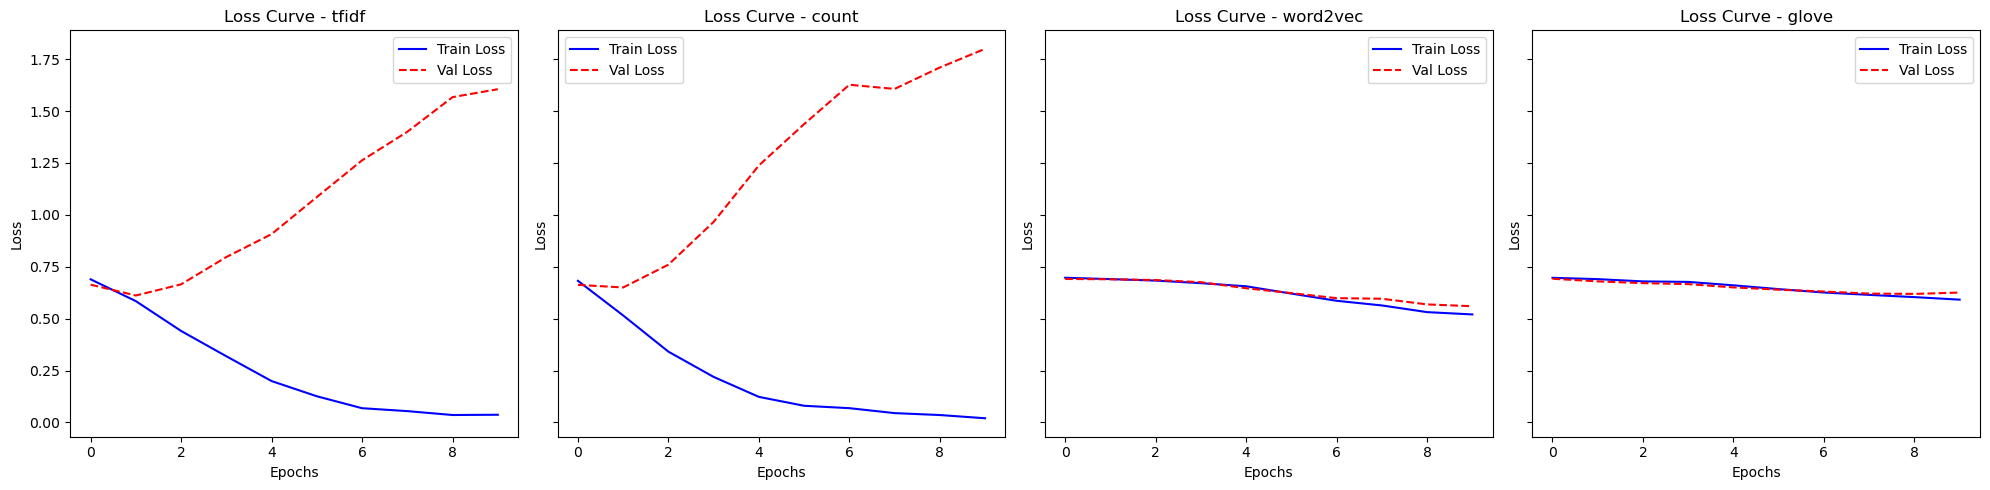

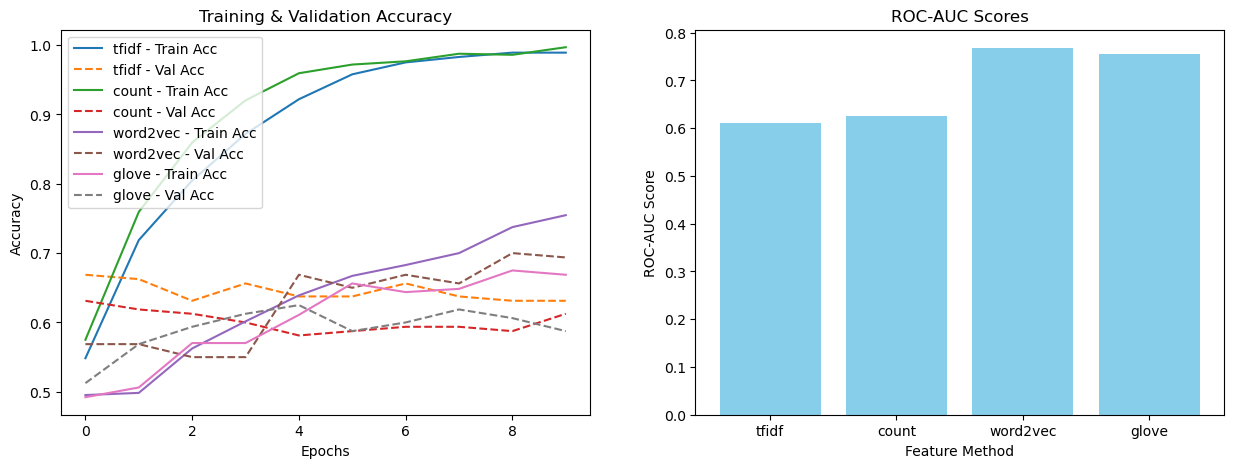

In [ ]:
# Number of methods
num_methods = len(results.keys())

# Create subplots (1 row, num_methods columns)
fig, axes = plt.subplots(1, num_methods, figsize=(5 * num_methods, 5), sharey=True)

# If only one method, axes will not be a list, so we ensure it's iterable
if num_methods == 1:
    axes = [axes]

# Plot Training & Validation Loss for each method in a separate subplot
for ax, method in zip(axes, results.keys()):
    ax.plot(results[method]["loss"], label="Train Loss", color="blue")
    ax.plot(results[method]["val_loss"], label="Val Loss", linestyle="dashed", color="red")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(f"Loss Curve - {method}")
    ax.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Plot Accuracy & ROC-AUC
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy Plot
axes[0].set_title("Training & Validation Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
for method in results.keys():
    axes[0].plot(results[method]["accuracy"], label=f"{method} - Train Acc")
    axes[0].plot(results[method]["val_accuracy"], label=f"{method} - Val Acc", linestyle="dashed")
axes[0].legend()

# ROC-AUC Plot (Bar Chart)
methods = list(results.keys())
roc_aucs = [results[m]["roc_auc"] for m in methods]
axes[1].bar(methods, roc_aucs, color="skyblue")
axes[1].set_title("ROC-AUC Scores")
axes[1].set_xlabel("Feature Method")
axes[1].set_ylabel("ROC-AUC Score")

plt.show()


## Something cute 2 LSTM

In [ ]:
for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name = "lstm"

        # Retrieve feature matrices
        X_train_features = np.array(X_train_features_dict[method])
        X_test_features = np.array(X_test_features_dict[method])

        # Ensure correct shape
        input_shape = (1, X_train_features.shape[1])
        X_train_features = X_train_features.reshape(X_train_features.shape[0], *input_shape)
        X_test_features = X_test_features.reshape(X_test_features.shape[0], *input_shape)
        
        # Get input shape dynamically
        input_shape = (X_train_features.shape[1], 1)

        # Initialize Keras Tuner
        tuner = kt.RandomSearch(
            lambda hp: build_lstm_model(hp, input_shape),
            objective="val_accuracy",
            max_trials=1,
            executions_per_trial=1,
            directory="tuner_results",
            project_name=f"lstm_tuning_{method}"
        )

        # Perform hyperparameter search
        tuner.search(X_train_features, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

        # Get the best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model = tuner.hypermodel.build(best_hps)

        # Train the best model
        history = best_model.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

        # Save the best model
        best_model.save(f"best_{model_name}_{method}.h5")

    except Exception as e:
        print(f"❌ Error with {method}: {e}")


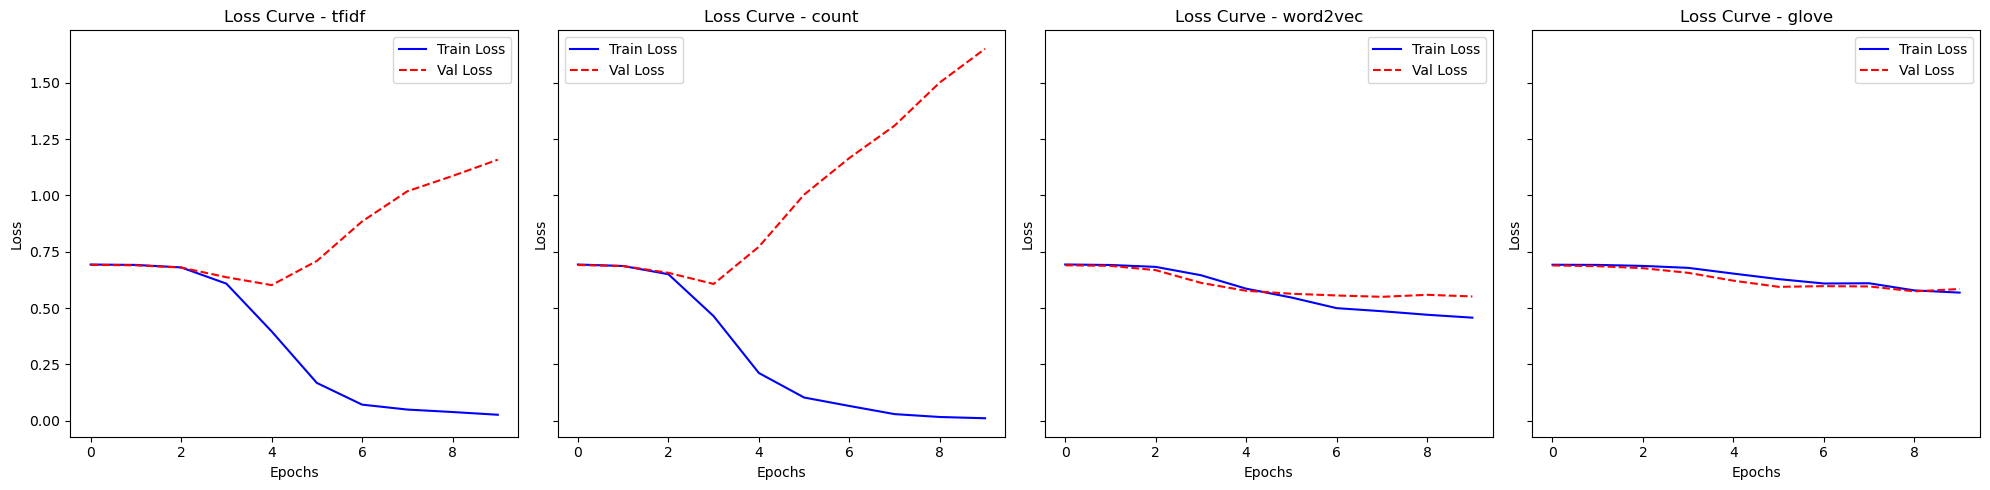

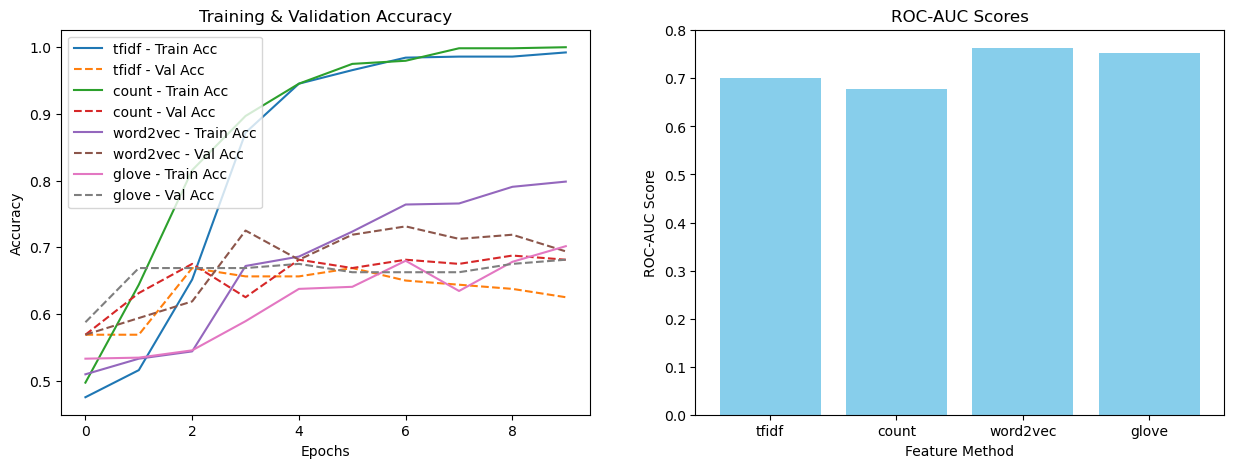

In [28]:
# Plot training & validation loss
num_methods = len(results.keys())
fig, axes = plt.subplots(1, num_methods, figsize=(5 * num_methods, 5), sharey=True)
if num_methods == 1:
    axes = [axes]
for ax, method in zip(axes, results.keys()):
    ax.plot(results[method]["loss"], label="Train Loss", color="blue")
    ax.plot(results[method]["val_loss"], label="Val Loss", linestyle="dashed", color="red")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(f"Loss Curve - {method}")
    ax.legend()
plt.tight_layout()
plt.show()

# Plot accuracy & ROC-AUC
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title("Training & Validation Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
for method in results.keys():
    axes[0].plot(results[method]["accuracy"], label=f"{method} - Train Acc")
    axes[0].plot(results[method]["val_accuracy"], label=f"{method} - Val Acc", linestyle="dashed")
axes[0].legend()

methods = list(results.keys())
roc_aucs = [results[m]["roc_auc"] for m in methods]
axes[1].bar(methods, roc_aucs, color="skyblue")
axes[1].set_title("ROC-AUC Scores")
axes[1].set_xlabel("Feature Method")
axes[1].set_ylabel("ROC-AUC Score")
plt.show()


## MLPClassifier chua chay duoc do qua lau

In [16]:
print("\n🔎 Running feature extraction and model training loop...\n")

for method in tqdm(feature_methods, desc="Feature Extraction Progress"):
    print(f"\n🔍 Processing feature extraction using: {method}...")

    try:
        model_name_mlp = "mlp"
        
        # Retrieve MLP model and hyperparameters
        mlp_algorithm = MODEL_DICT[model_name_mlp]()
        mlp_params = MODEL_PARAMS[model_name_mlp]

        # Train or load model
        trained_model = generate_binary_classification_model(
            X=X_train_features_dict[method], 
            y=y_train, 
            model_algorithm=mlp_algorithm, 
            hyperparameters=mlp_params, 
            needs_scaled=True,  # MLP requires feature scaling
            model_save_path=f"best_{model_name_mlp}_{method}.pkl",
            img_save_path=f"best_{model_name_mlp}_{method}.png",
            img_loss_path=f"best_{model_name_mlp}_{method}_loss.png"
        )

    except Exception as e:
        print(f"❌ Error with {method}: {e}")



🔎 Running feature extraction and model training loop...



Feature Extraction Progress:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Processing feature extraction using: tfidf...
🚀 Training new model: MLPClassifier...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


: 

: 

# Model Predict

In [15]:
# model_names = ["decision_tree", "logistic_regression", "random_forest", "xgboost", "perceptron", "bayesian_enhanced", "svm"]
model_names = ["decision_tree", "logistic_regression", "random_forest", "perceptron", "svm", "bayesian"]

In [ ]:
# Predict for each model
for model_name in model_names:
    for method in feature_methods:
        # Load the saved model
        model_filename = os.path.join(project_root, "src", "models", f"best_{model_name}_{method}.pkl")
        with open(model_filename, 'rb') as model_file:
            model = joblib.load(model_file)

        # Make predictions
        y_pred = model.predict(X_test_features_dict[method])

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        
        # ROC AUC can be computed if the model outputs probabilities
        # Handle models that do not support `predict_proba`
        if hasattr(model, "predict_proba"):
            print("Has predict_proba")
            y_prob = model.predict_proba(X_test_features_dict[method])[:, 1]  # Take the positive class probabilities
            roc_auc = roc_auc_score(y_test, y_prob)
        elif hasattr(model, "decision_function"):
            print("Has decision_function")
            y_prob = model.decision_function(X_test_features_dict[method])
            roc_auc = roc_auc_score(y_test, y_prob)
        else:
            print("Does not have predict_proba or decision_function")
            roc_auc = "N/A"  # Not applicable for models like Perceptron

        # Print metrics
        print(f"Model: {model_name}")
        print(f"Method: {method}")
        print("-" * 50)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if hasattr(model, "predict_proba") or hasattr(model, "decision_function"):
            print(f"ROC AUC: {roc_auc:.4f}")
        else:
            print("ROC AUC: N/A")
        print("-" * 50)
    print("%" * 50)

Has predict_proba
Model: decision_tree
Method: tfidf
--------------------------------------------------
Accuracy: 0.5300
Precision: 0.5190
Recall: 0.8200
F1 Score: 0.6357
ROC AUC: 0.5625
--------------------------------------------------
Has predict_proba
Model: decision_tree
Method: count
--------------------------------------------------
Accuracy: 0.5950
Precision: 0.6610
Recall: 0.3900
F1 Score: 0.4906
ROC AUC: 0.6132
--------------------------------------------------
Has predict_proba
Model: decision_tree
Method: word2vec
--------------------------------------------------
Accuracy: 0.6100
Precision: 0.5917
Recall: 0.7100
F1 Score: 0.6455
ROC AUC: 0.6072
--------------------------------------------------
Has predict_proba
Model: decision_tree
Method: glove
--------------------------------------------------
Accuracy: 0.5650
Precision: 0.5699
Recall: 0.5300
F1 Score: 0.5492
ROC AUC: 0.5854
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%